In [115]:
import os
import scipy.io
from scipy.stats import ranksums
from scipy.io import loadmat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from learned_tuning.learned_tuning import calculate_place_field_fidelity_of_learned_tuning, calculate_learned_tuning


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.nanstd(x) # the function to calculate z-score
normalize_to_max = lambda x:(x/np.nanmax(x))
gw = gausswindow(3, 9) # for smoothing the tunings 


main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (5, 12, 13)] # RatV sessions for now and Roy familiar sessions were excluded
current_sessions.append(5)


number_of_sessions = len(current_sessions)


# learned tunings and gini coefficients
overwrite_all = False

filename = f'learned_tunings_vs_posterior_gini_coeffs_NREM_QW.npy'
file_path = os.path.join('/home/kouroshmaboudi/Documents/Learned_tuning_Python', filename)

if os.path.exists(file_path) & (overwrite_all == False):

    print('Loading from existing data ...')
    load_data = np.load(file_path, allow_pickle=True).item()

    learned_tunings = load_data['learned_tunings']
    learned_tunings_place_field_corr = load_data['lt_pf_correlation']
    gini_coeffs = load_data['gini_coeffs']
    stable_above_1Hz_PF_unit_index = load_data['stable_above_1Hz_PF_unit_index']
    
else:

    stable_above_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)
    spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object)

    learned_tunings = np.empty((number_of_sessions,), dtype=object)
    gini_coeffs = np.empty((number_of_sessions,), dtype=object)
    learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)

    for session_idx in range(number_of_sessions):

        session_number = current_sessions[session_idx]
        session_name = rr[session_number]

        print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))


        session_dataset_path = os.path.join(main_dir, session_name)


        # Load epochs information
        filename = f'{session_name}.fileInfo_for_python.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = loadmat(file_path)
        session_info = mat_file["fileInfo"]

        epochs = session_info["behavior"][0][0][0][0]["time"]
        epoch_durations = epochs[:, 1] - epochs[:, 0]



        #---------------------------------------------------------------------------------------------
        # Brain state detection results

        if 0<=session_number<=4 or 6<=session_number<=10: # Grosmark and Giri datasets
            filename = f'{session_name}.brainStateDetection_HMMtheta_EMG_SWS_SchmidtTrigger.mat'
            file_path = os.path.join(session_dataset_path, filename)

            mat_file = scipy.io.loadmat(file_path)
            brainStates_bouts_label = mat_file['brainState']['bouts'][0][0][:, :-1]
            bouts_start_end = brainStates_bouts_label[:, :-1]
            bout_duration = bouts_start_end[:, 1] - bouts_start_end[:, 0] 
            bout_labels = brainStates_bouts_label[:, -1].astype(int)

            brainStates_names = []
            for i in range(4):
                brainStates_names.append(mat_file['brainState']['names'][0][0][i][0][0])

        else: # Miyawaki dataset
            filename = f'{session_name}.fileInfo_for_python.mat'
            file_path = os.path.join(session_dataset_path, filename)

            mat_file = scipy.io.loadmat(file_path)
            brainStates_bouts_label = mat_file['fileInfo']['brainStates'].item()

            bouts_start_end = brainStates_bouts_label[:, :-1]
            bout_duration = bouts_start_end[:, 1] - bouts_start_end[:, 0] 

            bout_labels = brainStates_bouts_label[:, -1].astype(int)

            # swapping the 3s and 4s, because the 3s in Hiro's brain_state_df are QWAKE while in the other datasets they are active wake(WAKE)
            bout_labels_temp = bout_labels.copy()
            bout_labels_temp[bout_labels == 3] = 4
            bout_labels_temp[bout_labels == 4] = 3
            bout_labels = bout_labels_temp[:]
            del bout_labels_temp

        brainStates_names = ['NREM', 'REM', 'WAKE', 'QWAKE', 'Undetermined']

        too_short_state_bout_index = np.where(bout_duration < 6)
        bout_labels[too_short_state_bout_index] = 5



        unique_state_labels = np.unique(bout_labels)
        num_bouts = bouts_start_end.shape[0]

        time_bins_centers = np.arange(0, bouts_start_end[-1,1]+1, 1)+0.5    
        time_bins_brain_state = np.full(time_bins_centers.shape, np.nan)

        for bout_idx, bout_timing in enumerate(bouts_start_end):
            inside_bout_idx = np.logical_and(bout_timing[0] < time_bins_centers,  time_bins_centers < bout_timing[1]) 
            time_bins_brain_state[inside_bout_idx] = bout_labels[bout_idx]


        chunk_size_in_hours = 1/60 # one minutes
        chunk_size = int(chunk_size_in_hours*3600) # in seconds
        num_chunks = len(time_bins_brain_state) // chunk_size
        chunk_start_times = [i*chunk_size_in_hours for i in range(num_chunks)] # centers of the time chunks
        
        reshaped_time_bins_brain_state = time_bins_brain_state[:num_chunks*chunk_size].reshape(num_chunks, chunk_size)

        bins = np.arange(1, unique_state_labels.shape[0]+2)
        counts = np.apply_along_axis(lambda x:np.histogram(x, bins = bins)[0] , axis = 1, arr=reshaped_time_bins_brain_state)


        # Normalize the counts to get percentages
        percentages = (counts / counts.sum(axis=1, keepdims=True))*100

        # Create a DataFrame with percentages for each category and each chunk
        brain_state_df = pd.DataFrame(percentages, columns=brainStates_names)



        """
        spatial tunings during MAZE and reMAZE
        """

        spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
        
        if session_number in [6, 7]: # RatN and RatS
            num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
        else:
            num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]

        num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size



        # Load unit stability information
        filename = f'{session_name}.cluster_quality_by_block'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = loadmat(file_path)
        cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]




        # print(num_units, num_pos_bins)

        spikes = []; # spike data and place field info of each unit

        # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
        running_directions = {'LR', 'RL', 'uni'}
        other_attributes   = {'spike_times', 'shank_id','cluster_id'}

        iter = 0
        for unit in range(num_units_total):
            
            # Create dictionaries for each unit and store the matrices
            
            unit_spikes = dict()
            
            unit_spikes['place_fields']  = {}
            unit_spikes['peak_pos_bins'] = {}

            
            for direction in running_directions:
                try:
                    if session_number in [6,7]:
                        unit_spikes['place_fields'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                        unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                    else:
                        unit_spikes['place_fields'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                        unit_spikes['peak_pos_bins'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]


                except ValueError:
                    if iter == 0:
                        print("This session has only one running direction")
                    iter += 1

            if session_number in [9, 10]: # for Rat V sessions
                unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
                unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1]
                unit_spikes['shank_id']    += 1
                unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

            elif session_number in [6, 7]: # for RatN and RatS
                unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
                unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]
                unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

            elif session_number == 8: # RatU  
                unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
                unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
                unit_spikes['shank_id']    += 1
                unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]
            else: # Grosmark, Hiro, and all other sessions
                unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
                unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # need to go one down for the other datasets
                unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]


            #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
            # Extract the cluster quality information by block for the current unit


            curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']-1] == unit_spikes['cluster_id'])[0]
            
            spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
            spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
            spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']-1][curr_unit_idx]# as a percentage of session mean
            unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

            firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
            firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
            # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
            if firing_rate_by_block.shape[1] == 2: 
                sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
            elif firing_rate_by_block.shape[1] == 3:
                sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

            if sleep_firing_rate > 0:
                firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
            else:
                firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

            unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

            isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']-1][curr_unit_idx]
            isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
            unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block


            try:
                unit_spikes['pre_post_unit_stability'] = (
                    # (unit_spikes['spike_amplitude_by_block'][0] > 0.8) & 
                    (unit_spikes['firing_rate_by_block'][0][:2] > 0.33) & 
                    (unit_spikes['isolation_distance_by_block'][0][:2] > 15)
                ).all()
            except:
                unit_spikes['pre_post_unit_stability'] = np.nan 


            spikes.append(unit_spikes) 

        # -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Process MAZE spatial tunings
        interp_pos_bins = np.linspace(0, num_pos_bins, 200)
        num_pos_bins_interp = len(interp_pos_bins)

        spatial_tunings_maze_before_normalization = np.zeros((num_units_total, num_pos_bins_interp))
        spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
        
        pre_post_unit_stability_curr_session = np.empty((num_units_total,))

        for unit in range(num_units_total):

            spatial_tuning_maze_curr_unit = spikes[unit]['place_fields']['uni']
            spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

            """
            Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
            """
            spatial_tunings_maze_before_normalization[unit] = spatial_tuning_maze_curr_unit
            spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)

            pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']


        stable_unit_index = pre_post_unit_stability_curr_session == True
        above_1Hz_PF_unit_index = np.nanmax(spatial_tunings_maze_before_normalization, axis=1) > 1
        
        stable_above_1Hz_PF_unit_index[session_idx]  = np.where(np.logical_and(stable_unit_index, above_1Hz_PF_unit_index))[0]


        # --------------------------------------------------------------------------------------------
        # Load cluster quality data (L-ratios)
        
        filename = f'{session_name}.clusterQuality.mat'
        file_path = os.path.join(session_dataset_path, filename)

        mat_file = scipy.io.loadmat(file_path)

        # Access data structure
        num_shanks = len(mat_file["clusterQuality"]["Lratio"][0])

        L_ratios = list()
        for shank in range(num_shanks):    
            curr_shank_L_ratios = dict()
            curr_shank_L_ratios["L_ratios"] = mat_file["clusterQuality"]["Lratio"][0][shank]
            curr_shank_L_ratios["cluster_ids"] = mat_file["clusterQuality"]["clus"][0][shank]
            
            L_ratios.append(curr_shank_L_ratios)


        #-------------------------------------------------------------------------------------------
        # Loading the population burst evenst with all their corresponding measured lfp features

        overwrite = False # in case we need to read the .mat file again, if there was a change

        filename = f'{session_name}.PBEs.pkl'
        file_path = os.path.join(session_dataset_path, filename)

        if os.path.exists(file_path) and overwrite == False:

            # PBEs = np.load(file_path, allow_pickle=True)
            PBEs = pd.read_pickle(file_path)
        else: # if it doesn't exist then read it from the .mat file

            filename = f'{session_name}.PBEInfo_replayScores_with_spindle_and_deltaPowers.mat'
            file_path = os.path.join(session_dataset_path, filename)
            f = h5py.File(file_path, "r")
            PBEInfo = f['PBEInfo_replayScores']    
        

            # Store the population burst events in a pandas DataFrame
            num_PBEs = PBEInfo["fr_1msbin"].shape[0]
            attributes = list(PBEInfo.keys())

            PBEs = pd.DataFrame(columns=[attr for attr in attributes[1:] if attr not in ['posteriorProbMat', 'postMat_nonNorm']])

            # Loop over the PBEs and add each one as a row to the DataFrame
            num_dots = int(num_PBEs * (10/100))
            count = 0

            for pbe in range(num_PBEs): #  
    
                for attr in PBEs.columns:
                    ref = PBEInfo[attr][pbe][0]
                    obj = f[ref]

                    if attr in ['epoch', 'brainState']: # convert the ascii code to string
                        arr = np.array(obj).flatten()
                        epoch = "".join(chr(code) for code in arr)
                        PBEs.at[pbe, attr] = epoch
                    elif attr in ['fr_1msbin', 'fr_20msbin', 'posteriorProbMat', 'postMat_nonNorm']: # no need to flatten
                        arr = np.array(obj)
                        PBEs.at[pbe, attr] = arr
                    else: 
                        arr = np.array(obj).flatten()
                        PBEs.at[pbe, attr] = arr

            if (pbe+1) % num_dots == 1:
                count += 1
                message = "Importing PBEs" + "." * count
                print(message, end="\r")

            print("All PBEs were imported") 
        
            filename = f'{session_name}.PBEs.pkl'
            file_path = os.path.join(session_dataset_path, filename)
            PBEs.to_pickle(file_path)

        num_PBEs = PBEs.shape[0]


        # add a brain state label depending on the time bin of the PBE
        for pbe in range(num_PBEs):
            idx = np.where(np.logical_and(time_bins_centers-0.5 <= PBEs.at[pbe, 'peakT'],  time_bins_centers+0.5 > PBEs.at[pbe, 'peakT']))[0]
            if len(idx) == 1:
                PBEs.at[pbe, 'brain_state'] = time_bins_brain_state[idx]
            else:
                PBEs.at[pbe, 'brain_state'] = ''



        # Calculate learned tunings seprately for NREM and QW PBEs 
        time_bin_duration = 0.02
        learned_tunings[session_idx] = {
            'pre': {'NREM': None, 'QW': None},
            'maze': {'NREM': None, 'QW': None},
            'post': {'NREM': None, 'QW': None}
        }

        gini_coeffs[session_idx] = {
            'pre': {'NREM': None, 'QW': None},
            'maze': {'NREM': None, 'QW': None},
            'post': {'NREM': None, 'QW': None}
        }

        learned_tunings_place_field_corr[session_idx] = {
            'pre': {'NREM': None, 'QW': None},
            'maze': {'NREM': None, 'QW': None},
            'post': {'NREM': None, 'QW': None}
        }

        num_shuffles = 10000
        for epoch in ['pre', 'maze', 'post']: # 
            if epoch == 'pre':
                epoch_idx = 0
                epoch_duration = epochs[0,1] - epochs[0,0]
                brain_states = ['NREM', 'QW']
            elif epoch == 'maze':
                epoch_idx = 1
                epoch_duration = epochs[1,1] - epochs[1, 0]
                brain_states = ['QW']
            elif epoch == 'post':
                epoch_idx = 2
                epoch_duration = 4*60*60 # limiting to the first 4 hours of post sleep
                brain_states = ['NREM', 'QW']

            if_inside_epoch = PBEs['peakT'].between(epochs[epoch_idx,0], epochs[epoch_idx,0]+epoch_duration)

            for brain_state in brain_states:

                print(f'Calculating learned tunings for {epoch} - {brain_state}')

                if brain_state == 'NREM':
                    brain_state_idx = 1
                elif brain_state == 'QW':
                    brain_state_idx = 4

                current_PBE_indexes = np.where(if_inside_epoch & (PBEs['brain_state'] == brain_state_idx))[0] # within the epoch and only includes NREM PBEs
            
                current_PBEs = PBEs.loc[current_PBE_indexes].reset_index(drop = True)
                
                original_learned_tunings, gini_coeffs[session_idx][epoch][brain_state] = calculate_learned_tuning(current_PBEs, spikes, L_ratios, time_bin_duration)
                learned_tunings[session_idx][epoch][brain_state] = np.full((num_units_total, num_pos_bins_interp), np.nan)

                for unit in range(num_units_total):
                    current_unit_lt = original_learned_tunings[unit].reshape(num_pos_bins)
                    current_unit_lt = np.interp(interp_pos_bins, np.arange(0, num_pos_bins), current_unit_lt)
                    current_unit_lt[np.isnan(current_unit_lt)] = 0

                    learned_tunings[session_idx][epoch][brain_state][unit] = np.convolve(current_unit_lt, gw, mode='same')


                learned_tunings_place_field_corr[session_idx][epoch][brain_state] = np.full((num_units_total,), np.nan)


                learned_tunings_place_field_corr[session_idx][epoch][brain_state][stable_above_1Hz_PF_unit_index[session_idx]], _, _ = calculate_place_field_fidelity_of_learned_tuning(
                    learned_tunings[session_idx][epoch][brain_state][stable_above_1Hz_PF_unit_index[session_idx]],
                    spatial_tunings_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]],  
                    num_shuffles
                )

    learned_tunings_vs_posterior_gini_coeffs_NREM_QW = dict()
    learned_tunings_vs_posterior_gini_coeffs_NREM_QW['learned_tunings'] = learned_tunings
    learned_tunings_vs_posterior_gini_coeffs_NREM_QW['gini_coeffs'] = gini_coeffs
    learned_tunings_vs_posterior_gini_coeffs_NREM_QW['lt_pf_correlation'] = learned_tunings_place_field_corr
    learned_tunings_vs_posterior_gini_coeffs_NREM_QW['spatial_tunings'] = spatial_tunings_maze
    learned_tunings_vs_posterior_gini_coeffs_NREM_QW['stable_above_1Hz_PF_unit_index'] = stable_above_1Hz_PF_unit_index

    np.save(file_path, learned_tunings_vs_posterior_gini_coeffs_NREM_QW)

Loading from existing data ...


In [109]:

filename = f'learned_tunings_vs_posterior_gini_coeffs_NREM_QW.npy'
file_path = os.path.join('/home/kouroshmaboudi/Documents/Learned_tuning_Python', filename)

load_data = np.load(file_path, allow_pickle=True).item()

learned_tunings = load_data['learned_tunings']
learned_tunings_place_field_corr = load_data['lt_pf_correlation']
gini_coeffs = load_data['gini_coeffs']
spatial_tunings_maze = load_data['spatial_tunings']
stable_above_1Hz_PF_unit_index = load_data['stable_above_1Hz_PF_unit_index']

In [116]:
# load REM learned tunings calculated in MATLAB

num_shuffles = 10000

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]


    session_dataset_path = os.path.join(main_dir, session_name)

    filename = f'{session_name}.assemblyTunings_REM_0.020.mat'
    file_path = os.path.join(session_dataset_path, 'NREM_REM_with_posterior_ginis', filename)
    mat_file = loadmat(file_path)
    
    for epoch in ['pre', 'post']:
    
        original_learned_tunings = mat_file['assemblyTunings'][epoch][0][0][0][0][0]

        gini_coeffs[session_idx][epoch]['REM'] = mat_file['posteriors_gini_coeffs'][epoch][0][0]

        num_units, num_pos_bins = original_learned_tunings.shape

        interp_pos_bins = np.linspace(0, num_pos_bins, 200)
        num_pos_bins_interp = len(interp_pos_bins)
    

        learned_tunings[session_idx][epoch]['REM'] = np.full((num_units, num_pos_bins_interp), np.nan)

        for unit in range(num_units):
            current_unit_lt = original_learned_tunings[unit].reshape(num_pos_bins)
            current_unit_lt = np.interp(interp_pos_bins, np.arange(0, num_pos_bins), current_unit_lt)
            current_unit_lt[np.isnan(current_unit_lt)] = 0

            learned_tunings[session_idx][epoch]['REM'][unit] = np.convolve(current_unit_lt, gw, mode='same')


        learned_tunings_place_field_corr[session_idx][epoch]['REM'] = np.full((num_units,), np.nan)
        learned_tunings_place_field_corr[session_idx][epoch]['REM'][stable_above_1Hz_PF_unit_index[session_idx]], _, _ = calculate_place_field_fidelity_of_learned_tuning(
                    learned_tunings[session_idx][epoch]['REM'][stable_above_1Hz_PF_unit_index[session_idx]],
                    spatial_tunings_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]],  
                    num_shuffles
                )


/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


### Concatenate the learned tunings and Gini coefficients across sessions

In [117]:
# Concatenate the data from different sessions 
# For NREM, QW ripples for now 
# We need to add the MAZE theta and PRE/POST REM periods to these as well

epoch_names = ['pre', 'maze', 'post']

#------------------------------------------------------------------------------------------------------------
# Learned tuning maze PF correlations
learned_tunings_place_field_corr_pooled = {
            'pre': {'NREM': None, 'QW': None, 'REM': None},
            'maze': {'NREM': None, 'QW': None, 'REM': None},
            'post': {'NREM': None, 'QW': None, 'REM': None}
        }

for epoch in epoch_names:
    if epoch == 'pre':
        brain_states = ['NREM', 'QW', 'REM']
    elif epoch == 'maze':
        brain_states = ['QW']
    elif epoch == 'post':
        brain_states = ['NREM', 'QW', 'REM'] 

    for brain_state in brain_states:
        arr = []
        for session_idx in range(number_of_sessions):
            arr.append(learned_tunings_place_field_corr[session_idx][epoch][brain_state][stable_above_1Hz_PF_unit_index[session_idx]])
        learned_tunings_place_field_corr_pooled[epoch][brain_state] = np.concatenate(arr, axis = 0)


#-------------------------------------------------------------------------------------------------------------
# Mean Posterior's gini coefficient for each unit for each epoch

# Mean Gini coefficient 

mean_gini_coeffs = np.empty((number_of_sessions,), dtype=object)
for session_idx in range(number_of_sessions):
    mean_gini_coeffs[session_idx] = {
                'pre': {'NREM': None, 'QW': None, 'REM': None},
                'maze': {'NREM': None, 'QW': None, 'REM': None},
                'post': {'NREM': None, 'QW': None, 'REM': None}
            }

# Pooled
mean_gini_coeffs_pooled = {
            'pre': {'NREM': None, 'QW': None, 'REM': None},
            'maze': {'NREM': None, 'QW': None, 'REM': None},
            'post': {'NREM': None, 'QW': None, 'REM': None}
        }

for epoch in epoch_names:
    if epoch == 'pre':
        brain_states = ['NREM', 'QW', 'REM']
    elif epoch == 'maze':
        brain_states = ['QW']
    elif epoch == 'post':
        brain_states = ['NREM', 'QW','REM'] 

    for brain_state in brain_states:
        arr = []
        for session_idx in range(number_of_sessions):
            current_gini_coeffs = gini_coeffs[session_idx][epoch][brain_state]
            mean_gini_coeffs[session_idx][epoch][brain_state] = np.nanmean(current_gini_coeffs, axis = 1)

            arr.append(mean_gini_coeffs[session_idx][epoch][brain_state][stable_above_1Hz_PF_unit_index[session_idx]])
        
        mean_gini_coeffs_pooled[epoch][brain_state] = np.concatenate(arr, axis = 0)




/tmp/ipykernel_106547/1500638393.py:62: RuntimeWarning: Mean of empty slice
  mean_gini_coeffs[session_idx][epoch][brain_state] = np.nanmean(current_gini_coeffs, axis = 1)
/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


### Plot

/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Group: NREM
Group: QW
Group: REM


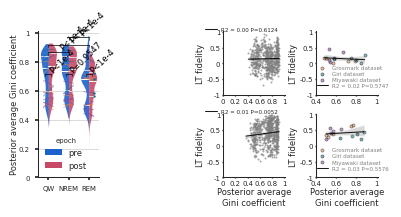

In [127]:
from scipy.stats import wilcoxon, friedmanchisquare,linregress
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker


#----------------------------------------------------------------------------------------------------------
# Define functions

def remove_trailing_zeros(x, pos):
    formatted_label = f"{int(x):d}" if x == int(x) else f"{x:.1f}"
    return formatted_label

# def get_pval_statement(pvalue, sign):
#     if pvalue < 0.0001:
#         pvalue_statement = sign*2    
#     elif pvalue < 0.01:
#         pvalue_statement = sign
#     else:
#         pvalue_statement = 'ns'
#     return pvalue_statement



def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement


def plot_violin(ax, data, color, xvar, yvar, zvar):

    """
    customized Seaborn violon plot
    """

    alpha = 0.9
    order = ['QW', 'NREM', 'REM']
    vio = sns.violinplot(data=data, x = xvar, y = yvar, order = order, hue=zvar, split=True, cut=0, inner='quartiles', ax=ax, palette=color, linewidth=0, capstyle='butt')
    for violin, curr_alpha in zip(ax.collections[::1], [alpha] * 6):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.5)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(.75)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    # for axis in ['left', 'bottom']:
    #     ax.spines[axis].set_linewidth(1.5)

    # vio.legend(loc="upper center", bbox_to_anchor=(0.5, 1.5))
    vio.set_title("")

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':5,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 

dataset_specific_colors = ["#E58044", "#046C7C", "#85459B"] # "#BDA55D" 
dataset_labels = ["Grosmark dataset", "Giri dataset", "Miyawaki dataset"]

#----------------------------------------------------------------------------------------------------------------
# Generate a dataframe

def get_dataframe(data, yvariable_name):
    
    """
    To generate a dataframe version of the dictionaries corresponding to LT-PF correlation or gini coefficients
    """ 
    
    epoch_names = []
    brain_states = []
    yvars = [] # It can be LT-PF correlation, gini coeffs, etc

    for epoch_name, value in data.items(): # the keys will be the epochs
        for brain_state, yvar in value.items():
            if yvar is not None:
                current_num_units = len(yvar)
                epoch_names.append([epoch_name]*current_num_units)
                brain_states.append([brain_state]*current_num_units)
                yvars.append(yvar)

    epoch_names  = np.concatenate(epoch_names, axis = 0)
    brain_states = np.concatenate(brain_states, axis = 0)
    yvars = np.concatenate(yvars, axis = 0)

    df = pd.DataFrame({
        "epoch": epoch_names,
        "brain_state":brain_states,
        yvariable_name: yvars
    })

    return df


mean_gini_coeffs_df = get_dataframe(mean_gini_coeffs_pooled, 'posterior_mean_gini_coeff')
lt_pf_correlation_df = get_dataframe(learned_tunings_place_field_corr_pooled , 'lt_pf_correlation')

learned_tuning_df = lt_pf_correlation_df.copy()
learned_tuning_df['posterior_mean_gini_coeff'] = mean_gini_coeffs_df['posterior_mean_gini_coeff']



#---------------------------------------------------------------------------------------------------------------
# Create figure and subplots

plotheight = 2
plotwidth = 4
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth, plotheight])
gs = GridSpec(nrows=2, ncols=4, figure=fig, hspace=0.3, wspace=0.5)


# Violin plot
y_variables = ['posterior_mean_gini_coeff'] # , 'lt_pf_correlation'
y_variable_names = ['Posterior average Gini coefficient', 'LT fidelity']
brain_states = ['QW', 'NREM', 'REM'] 
num_brain_states = len(brain_states)

epoch_to_analyze = ['pre', 'post']
filtered_learned_tuning_df = learned_tuning_df[learned_tuning_df['epoch'].isin(['pre', 'post'])]

size_effect = dict.fromkeys(y_variables)

for y_variable_index, y_variable in enumerate(y_variables):

    size_effect[y_variable] = dict()

    ax0 = fig.add_subplot(gs[:,y_variable_index])

    plot_violin(ax0, filtered_learned_tuning_df, colors, 'brain_state', y_variable,  'epoch')

    # Drawing the medians for each session
    for brain_state_idx, brain_state in enumerate(brain_states):
        for session_idx in range(number_of_sessions):        
            
            session_number = current_sessions[session_idx]

            if y_variable == 'posterior_mean_gini_coeff':
                curr_arr = mean_gini_coeffs
            elif y_variable == 'lt_pf_correlation':
                curr_arr = learned_tunings_place_field_corr

            current_session_medians = [np.nanmedian(curr_arr[session_idx][epoch][brain_state]) for epoch in ['pre', 'post']]

            if session_number in range(5):
                color = dataset_specific_colors[0]
            elif session_number in range(6,11):
                color = dataset_specific_colors[1]
            else:
                color = dataset_specific_colors[2]
            
            if np.all(np.isfinite(current_session_medians)):
                ax0.plot([brain_state_idx-0.25, brain_state_idx+0.25], current_session_medians, linewidth= 0.5, color=color, alpha=0.7) 
            else:
                ax0.scatter(brain_state_idx+0.25, current_session_medians[1], s = 0.5, color=color, alpha=1)
        
        current_data = [filtered_learned_tuning_df.loc[
            (filtered_learned_tuning_df['brain_state'] == brain_state) 
            & (filtered_learned_tuning_df['epoch'] == epoch), y_variable].values for epoch in ['pre', 'post']]
        current_data = np.array(current_data)
        current_data = np.transpose(current_data)

        unit_indexes_with_valid_values = np.all(np.isfinite(current_data), axis=1)
        current_data = current_data[unit_indexes_with_valid_values]
        _, p_value = wilcoxon(current_data[:,0], current_data[:,1], nan_policy='omit')

        # Calculate the size effect (paired)
        difference = current_data[:,1] - current_data[:,0]
        size_effect[y_variable][brain_state] = np.nanmean(difference)/np.std(difference)

        significance_line_y = 0.7*ax0.get_ylim()[1]
        ax0.plot([brain_state_idx-0.15, brain_state_idx+0.15], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
        [ax0.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [brain_state_idx-0.15, brain_state_idx+0.15]]
        
        ax0.annotate(get_pval_statement(p_value), xy = (brain_state_idx, significance_line_y), color = 'black', ha = "left", va="bottom", rotation = 45, fontsize = 6)


    # Test the significant effect of brain states on the y variables
    grouped_data=filtered_learned_tuning_df.groupby("brain_state")
    for label, group in grouped_data:
        print(f"Group: {label}")

    grouped_data = [group[y_variable].values for _, group in filtered_learned_tuning_df.groupby("brain_state")] # the order is NREM, QW, REM
    grouped_data = np.transpose(np.array(grouped_data))
    # grouped_data = grouped_data[:, [1,0,2]] # change the order to QW, NREM, and REM to remian consistent with the rest of the code regarding the order of brain states


    # first using the Friedman chi square test
    not_nan_idx = np.where(~np.isnan(grouped_data).any(axis=1))[0]
    data_array_cln = grouped_data[not_nan_idx]
    statsitic, friedman_p_value = friedmanchisquare(data_array_cln[:, 0], data_array_cln[:, 1], data_array_cln[:, 2])
    # print(friedman_p_value)

    # # Post-hoc analysis using wilcoxon signed-rank to test the differences between each pair of brain states
    
    post_hoc_p_values = np.full((num_brain_states, num_brain_states), np.nan)

    for brain_state_i in range(num_brain_states):
        for brain_state_j in range(brain_state_i+1, num_brain_states):

            _, post_hoc_p_values[brain_state_i, brain_state_j] = wilcoxon(grouped_data[:, brain_state_i], grouped_data[:, brain_state_j], nan_policy='omit')
           
            significance_line_y = (0.8+0.05*(brain_state_i+brain_state_j))*ax0.get_ylim()[1]

            ax0.plot([brain_state_i, brain_state_j], [significance_line_y, significance_line_y], color = 'black', linewidth=0.5) 
            [ax0.plot([x, x], [significance_line_y*0.98, significance_line_y], color = 'black', linewidth=0.5, alpha=0.8) for x in [brain_state_i, brain_state_j]]
           
            ax0.annotate(get_pval_statement(post_hoc_p_values[brain_state_i, brain_state_j]), xy = (np.mean([brain_state_i, brain_state_j]), significance_line_y), color = 'black', ha = "left", va="bottom", rotation = 45, fontsize = 6)



    if y_variable_index == 0:
        ax0.set_ylim([0, 1.01])
        ax0.set_yticks(np.linspace(0, 1, 6))
    else:
        ax0.set_ylim([-1, 1.01])
        ax0.set_yticks(np.linspace(-1, 1, 5))


    ax0.set_xlabel('')
    ax0.set_ylabel(y_variable_names[y_variable_index], labelpad=0)
    ax0.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


#------------------------------------------------------------------------------------------------------------
# correlation between the gini coefficients and LT fidelities

for epoch_index, epoch in enumerate(['pre', 'post']):
    ax1 = fig.add_subplot(gs[epoch_index,2])

    current_epoch_data_frame = learned_tuning_df[(learned_tuning_df['epoch'] == epoch) & (learned_tuning_df['brain_state'] == 'NREM')]

    xvar = current_epoch_data_frame['posterior_mean_gini_coeff']
    yvar = current_epoch_data_frame['lt_pf_correlation'] 

    valid_indexes = ~np.isnan(xvar) & ~np.isnan(yvar) 
    xvar = xvar[valid_indexes]
    yvar = yvar[valid_indexes]

    sns.scatterplot(
        x=xvar,
        y=yvar,
        color = 'gray',
        marker='o',
        edgecolor = 'black',
        linewidth=0, 
        s=2, 
        alpha=0.7, 
        ax=ax1, 
        )

    # Add the best-fit line

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(xvar, yvar)
    line = slope * xvar + intercept

    sns.regplot(x=xvar, y=yvar, ci=95, color='black', scatter=False,
                label=f'R2 = {r_value**2:.2f} {get_pval_statement(p_value)}',
                line_kws={"linewidth":0.75, "alpha":.9},
                ax=ax1)


    ax1.set_xlim([0, 1.01])
    ax1.set_ylim([-1, 1.01])

    ax1.set_xticks(np.linspace(0, 1, 6))
    ax1.set_yticks(np.linspace(-1, 1, 5))

    if epoch_index == 1:
        ax1.set_xlabel("Posterior average\nGini coefficient", labelpad=1)
    else:
        ax1.set_xlabel('')
        
    ax1.set_ylabel("LT fidelity", labelpad=1)
    ax1.tick_params(axis='both', which='major', length=1, pad=1, width=1)

    ax1.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.15))

    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))


#---------------------------------------------------------------------------------------------------
# Correlation between the median gini coefficients and LT fidelities across sessions 

current_brain_state = 'NREM'

for epoch_index, epoch in enumerate(['pre', 'post']):
    ax2 = fig.add_subplot(gs[epoch_index,3])

    session_median_ginis = np.full((number_of_sessions,), np.nan)
    session_median_fidelities = np.full((number_of_sessions,), np.nan)
    session_dataset_number = np.full((number_of_sessions,), np.nan)

    for session_idx in range(number_of_sessions):

        session_number = current_sessions[session_idx]

        session_median_ginis[session_idx] = np.nanmedian(mean_gini_coeffs[session_idx][epoch][current_brain_state])
        session_median_fidelities[session_idx] = np.nanmedian(learned_tunings_place_field_corr[session_idx][epoch][current_brain_state])

        if session_number in range(5):
            session_dataset_number[session_idx] = 0
        elif session_number in range(6,11):
            session_dataset_number[session_idx] = 1
        else:
            session_dataset_number[session_idx] = 2
            

    current_epoch_data_frame = learned_tuning_df[learned_tuning_df['epoch'] == epoch]

    xvar = session_median_ginis
    yvar = session_median_fidelities 

    # valid_indexes = ~np.isnan(xvar) & ~np.isnan(yvar) 
    # xvar = xvar[valid_indexes]
    # yvar = yvar[valid_indexes]

    for dataset_index in range(3):
        current_index = session_dataset_number == dataset_index
        sns.scatterplot(
            x=xvar[current_index],
            y=yvar[current_index],
            color = dataset_specific_colors[dataset_index],
            marker='o',
            edgecolor = 'black',
            linewidth= 0.5, 
            s=5, 
            alpha=0.5, 
            ax=ax2,
            label = dataset_labels[dataset_index]
            )

    # Add the best-fit line

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(xvar, yvar)
    line = slope * xvar + intercept

    sns.regplot(x=xvar, y=yvar, ci=95, color='black', scatter=False,
                label=f'R2 = {r_value**2:.2f} {get_pval_statement(p_value)}',
                line_kws={"linewidth":0.75, "alpha":.9},
                ax=ax2)


    ax2.set_xlim([0.4, 1.01])
    ax2.set_ylim([-1, 1.01])

    ax2.set_xticks(np.linspace(0.4, 1, 4))
    ax2.set_yticks(np.linspace(-1, 1, 5))

    if epoch_index == 1:
        ax2.set_xlabel("Posterior average\nGini coefficient", labelpad=1)
    else:
        ax2.set_xlabel('')
        
    ax2.set_ylabel("LT fidelity", labelpad=1)
    ax2.tick_params(axis='both', which='major', length=1, pad=1, width=1)

    ax2.xaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))
    ax2.yaxis.set_major_formatter(ticker.FuncFormatter(remove_trailing_zeros))

    ax2.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.6, 0.55), markerscale = 1, labelspacing= 0.2, labelcolor = 'gray')


plt.subplots_adjust(left=0.10, right= 0.95, bottom=0.1, top=0.83)

filename = 'learned_tunings_gini_coefficients_and_PF_fidelity.pdf'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, dpi=300)






In [128]:
size_effect

{'posterior_mean_gini_coeff': {'QW': 0.2027349635662909,
  'NREM': 0.03627916956609918,
  'REM': -0.28924754613987697}}

### REM posterior sharpness for different time bin durations

In [ ]:
# load REM learned tunings calculated in MATLAB

REM_time_bin_durations = [0.02, 0.05, 0.125, 0.25, 0.5, 1, 2]
epoch_names = ['pre', 'post']

num_shuffles = 10000

matlab_dir = '/home/kouroshmaboudi/Documents/NCMLproject/assemblyTuning_finalResults'

mean_gini_coeffs_REM = np.empty((number_of_sessions,), dtype=object)

for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]
    session_dataset_path = os.path.join(matlab_dir, session_name, 'assemblyTunings')

    mean_gini_coeffs_REM[session_idx] = dict.fromkeys(epoch_names)
    for epoch in epoch_names:
        mean_gini_coeffs_REM[session_idx][epoch] = dict.fromkeys(REM_time_bin_durations)


    for time_bin_duration in REM_time_bin_durations:

        filename = f'{session_name}.assemblyTunings_REM_{time_bin_duration:.3f}.mat'
        file_path = os.path.join(session_dataset_path, 'NREM_REM_with_posterior_ginis', filename)
        mat_file = loadmat(file_path)
        
        for epoch in epoch_names:
            current_gini_coeffs = mat_file['posteriors_gini_coeffs'][epoch][0][0]
            mean_gini_coeffs_REM[session_idx][epoch][time_bin_duration] = np.nanmean(current_gini_coeffs, axis = 1)

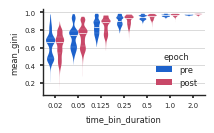

In [187]:
def get_dataframe(mean_gini_coeffs_REM):

    """
    To generate a dataframe version of the dictionaries corresponding to REM gini coefficients
    """ 

    num_sessions = len(mean_gini_coeffs_REM)
    unique_epochs = list(mean_gini_coeffs_REM[0].keys())

    unique_time_bin_durations = list(mean_gini_coeffs_REM[0][unique_epochs[0]].keys())

    session_indices = []
    epoch_names = []
    time_bin_durations = []
    REM_ginis = []

    for session_idx in range(num_sessions):
        for epoch in unique_epochs:
            for time_bin in unique_time_bin_durations:
                current_ginis = mean_gini_coeffs_REM[session_idx][epoch][time_bin]
                current_num_units = len(current_ginis)

                REM_ginis.extend(current_ginis)
                session_indices.extend([session_idx]*current_num_units)
                epoch_names.extend([epoch]*current_num_units)
                time_bin_durations.extend([time_bin]*current_num_units) 

    df = pd.DataFrame({
        "epoch": epoch_names,
        "time_bin_duration": time_bin_durations,
        "mean_gini": REM_ginis,
        "session_index": session_indices
    })

    return df


def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement


def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)



def plot_violin(ax, data, color, xvar, yvar, zvar):

    """
    customized Seaborn violon plot
    """
    alpha = 0.9
    vio = sns.violinplot(data=data, x = xvar, y = yvar, hue=zvar, split=False, inner='quartiles', cut=0, ax=ax, palette=color, linewidth=0, capstyle='butt') # 

    # for violin, curr_alpha in zip(ax.collections[::1], [alpha] * 6):
    #     violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(0.1)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(.5)
        l.set_color('white')
        l.set_alpha(1)
    ax.grid(axis='y', color=(.8,.8,.8), linewidth=0.5)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1)

    vio.set_title("")


# set plot style and context

sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})


colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 



mean_gini_coeffs_REM_df = get_dataframe(mean_gini_coeffs_REM)


# set plot size nnd create a plot
plotheight = 80
plotwidth = 150
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.3)


ax0 = fig.add_subplot(gs[0])

plot_violin(ax0, mean_gini_coeffs_REM_df, colors, "time_bin_duration", "mean_gini", "epoch")

filename = 'REM_posterior_gini_vs_time_bin_duration.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()



In [180]:
main_dir

'/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'

In [126]:

def gini(x):
    # Mean absolute difference 
    mad = np.abs(np.subtract.outer(x,x)).mean()
    # Relative mean absoulte difference 
    if np.mean(x) > 0:
        rmad = mad/np.mean(x)
    else:
        rmad = np.nan
    # Gini coefficient 
    g = 0.5*rmad
    return g


x = [0, 1, 9, 0, 0.1, 5, 1]
gini(x)

0.6725820763087843

In [81]:
mean_gini_coeffs = {
        'pre': {'NREM': None, 'QW': None},
        'maze': {'NREM': None, 'QW': None},
        'post': {'NREM': None, 'QW': None}
        }
for epoch in ['pre', 'maze', 'post']:
    if epoch in ['pre', 'post']:
        current_brain_states = brain_states
    else:
         current_brain_states = ['QW']

    for brain_state in current_brain_states:
        current_gini_coefficients = gini_coeffs[8][epoch][brain_state]
        mean_gini_coeffs[epoch][brain_state] = np.full((num_units,), np.nan)
        mean_gini_coeffs[epoch][brain_state] = np.nanmean(current_gini_coefficients, axis = 1)
        #[stable_above_1Hz_PF_unit_index]

/tmp/ipykernel_163462/1164919128.py:15: RuntimeWarning: Mean of empty slice
  mean_gini_coeffs[epoch][brain_state] = np.nanmean(current_gini_coefficients, axis = 1)


In [49]:
from scipy.stats import wilcoxon

data_0 = mean_gini_coeffs['pre']['QW']#[stable_above_1Hz_PF_unit_index]
data_1 = mean_gini_coeffs['post']['NREM']#[stable_above_1Hz_PF_unit_index]


valid_indexes = ~np.isnan(data_0) & ~np.isnan(data_1)

a, b = wilcoxon(data_0[valid_indexes], data_1[valid_indexes])

print(a)
print(b)
print(np.nanmean(data_0))
print(np.nanmean(data_1))

4977.0
0.000535892040324991
0.8740741963681767
0.8764156657038561


In [ ]:
lt_pf_fidelity = learned_tunings[8]['pre']['QW']#[stable_above_1Hz_PF_unit_index]
gini_coeff = mean_gini_coeffs['pre']['QW']#[stable_above_1Hz_PF_unit_index]


plt.figure()
plt.scatter(gini_coeff, lt_pf_fidelity)


from scipy.stats import pearsonr 

valid_indexes = ~np.isnan(gini_coeff) & ~np.isnan(lt_pf_fidelity)
a,b = pearsonr(gini_coeff[valid_indexes], lt_pf_fidelity[valid_indexes])
print(a)
print(b)
